https://towardsdatascience.com/ensembling-convnets-using-keras-237d429157eb

In [21]:
from keras.models import Model, Input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Average, Dropout
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
from keras.datasets import cifar10
import os

import numpy as np
os.chdir('/home/digits/jupyter/chtseng')

In [22]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train / 255.
x_test = x_test / 255.
y_train = to_categorical(y_train, num_classes=10)

In [23]:
print('x_train shape: {} | y_train shape: {}\nx_test shape : {} | y_test shape : {}'.format(x_train.shape, y_train.shape,                                                                                      x_test.shape, y_test.shape))

x_train shape: (50000, 32, 32, 3) | y_train shape: (50000, 10)
x_test shape : (10000, 32, 32, 3) | y_test shape : (10000, 1)


In [24]:
input_shape = x_train[0,:,:,:].shape
model_input = Input(shape=input_shape)

In [25]:
def compile_and_train(model, num_epochs): 
    
    model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['acc']) 
    filepath = 'weights/' + model.name + '.{epoch:02d}-{loss:.2f}.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_weights_only=True, save_best_only=True, mode='auto', period=1)
    tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0, batch_size=32)
    history = model.fit(x=x_train, y=y_train, batch_size=32, epochs=num_epochs, verbose=1, callbacks=[checkpoint, tensor_board], validation_split=0.2)
    return history

import matplotlib.pyplot as plt
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train history')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    legendLoc = 'lower right' if(train=='acc') else 'upper right'
    plt.legend(['train', 'validation'], loc=legendLoc)
    plt.show()

In [26]:
def conv_pool_cnn(model_input):
    
    x = Conv2D(96, kernel_size=(3, 3), activation='relu', padding = 'same')(model_input)
    x = Conv2D(96, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(96, (3, 3), activation='relu', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides = 2)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides = 2)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (1, 1), activation='relu')(x)
    x = Conv2D(10, (1, 1))(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation(activation='softmax')(x)
    
    model = Model(model_input, x, name='conv_pool_cnn')
    
    return model

def all_cnn(model_input):
    
    x = Conv2D(96, kernel_size=(3, 3), activation='relu', padding = 'same')(model_input)
    x = Conv2D(96, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(96, (3, 3), activation='relu', padding = 'same', strides = 2)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same', strides = 2)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (1, 1), activation='relu')(x)
    x = Conv2D(10, (1, 1))(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation(activation='softmax')(x)
        
    model = Model(model_input, x, name='all_cnn')
    
    return model

def nin_cnn(model_input):
    
    #mlpconv block 1
    x = Conv2D(32, (5, 5), activation='relu',padding='valid')(model_input)
    x = Conv2D(32, (1, 1), activation='relu')(x)
    x = Conv2D(32, (1, 1), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.5)(x)
    
    #mlpconv block2
    x = Conv2D(64, (3, 3), activation='relu',padding='valid')(x)
    x = Conv2D(64, (1, 1), activation='relu')(x)
    x = Conv2D(64, (1, 1), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.5)(x)
    
    #mlpconv block3
    x = Conv2D(128, (3, 3), activation='relu',padding='valid')(x)
    x = Conv2D(32, (1, 1), activation='relu')(x)
    x = Conv2D(10, (1, 1))(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Activation(activation='softmax')(x)
    
    model = Model(model_input, x, name='nin_cnn')
    
    return model



In [27]:
conv_pool_cnn_model = conv_pool_cnn(model_input)
print(conv_pool_cnn_model.summary())
all_cnn_model = all_cnn(model_input)
print(all_cnn_model.summary())
nin_cnn_model = nin_cnn(model_input)
print(nin_cnn_model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 32, 32, 96)        2688      
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 32, 32, 96)        83040     
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 32, 32, 96)        83040     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 15, 15, 96)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 15, 15, 192)       166080    
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 15, 15, 192)       331968    
__________

In [28]:
history_conv_pool_cnn_model = compile_and_train(conv_pool_cnn_model, num_epochs=20)
history_all_cnn_model = compile_and_train(all_cnn_model, num_epochs=20)
history_nin_cnn_model = compile_and_train(nin_cnn_model, num_epochs=20)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 14s 358us/step - loss: 1.7879 - acc: 0.3111 - val_loss: 1.4813 - val_acc: 0.4270
Epoch 2/20
40000/40000 [==============================] - 13s 332us/step - loss: 1.3308 - acc: 0.5077 - val_loss: 1.2289 - val_acc: 0.5486
Epoch 3/20
40000/40000 [==============================] - 13s 335us/step - loss: 1.0781 - acc: 0.6117 - val_loss: 0.9841 - val_acc: 0.6412
Epoch 4/20
40000/40000 [==============================] - 13s 336us/step - loss: 0.8808 - acc: 0.6860 - val_loss: 0.8564 - val_acc: 0.7039
Epoch 5/20
40000/40000 [==============================] - 13s 337us/step - loss: 0.7471 - acc: 0.7380 - val_loss: 0.8729 - val_acc: 0.7011
Epoch 6/20
40000/40000 [==============================] - 14s 338us/step - loss: 0.6446 - acc: 0.7752 - val_loss: 0.7218 - val_acc: 0.7510
Epoch 7/20
40000/40000 [==============================] - 14s 344us/step - loss: 0.5711 - acc: 0.8002 - val_loss: 0.

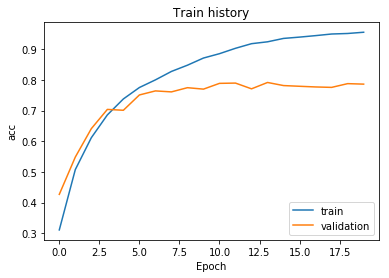

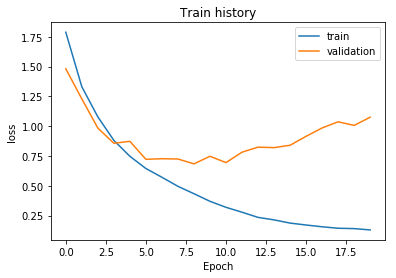

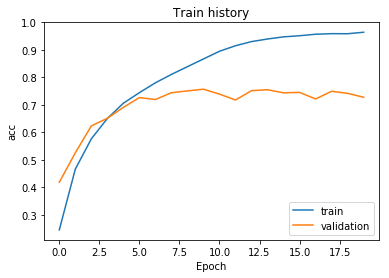

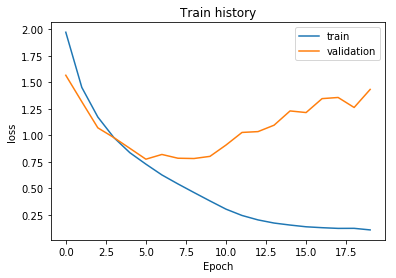

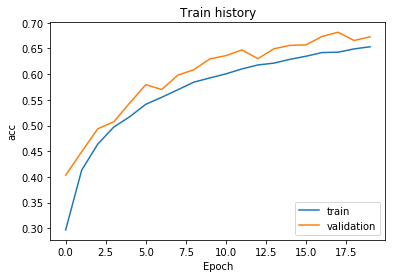

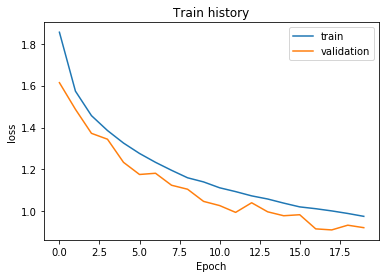

In [29]:
show_train_history(history_conv_pool_cnn_model, 'acc', 'val_acc')
show_train_history(history_conv_pool_cnn_model, 'loss', 'val_loss')

show_train_history(history_all_cnn_model, 'acc', 'val_acc')
show_train_history(history_all_cnn_model, 'loss', 'val_loss')

show_train_history(history_nin_cnn_model, 'acc', 'val_acc')
show_train_history(history_nin_cnn_model, 'loss', 'val_loss')

In [46]:
CONV_POOL_CNN_WEIGHT_FILE = os.path.join(os.getcwd(), 'weights', 'conv_pool_cnn.20-0.13.hdf5')
ALL_CNN_WEIGHT_FILE = os.path.join(os.getcwd(), 'weights', 'all_cnn.20-0.11.hdf5')
NIN_CNN_WEIGHT_FILE = os.path.join(os.getcwd(), 'weights', 'nin_cnn.20-0.98.hdf5')

conv_pool_cnn_model = conv_pool_cnn(model_input)
all_cnn_model = all_cnn(model_input)
nin_cnn_model = nin_cnn(model_input)

conv_pool_cnn_model.load_weights(CONV_POOL_CNN_WEIGHT_FILE)
all_cnn_model.load_weights(ALL_CNN_WEIGHT_FILE)
nin_cnn_model.load_weights(NIN_CNN_WEIGHT_FILE)

models = [conv_pool_cnn_model, all_cnn_model, nin_cnn_model]
two_models_1 = [conv_pool_cnn_model, all_cnn_model]
two_models_2 = [conv_pool_cnn_model, nin_cnn_model]
two_models_3 = [all_cnn_model, nin_cnn_model]

In [42]:
from typing import Tuple, List
from keras.engine import training
from tensorflow.python.framework.ops import Tensor

def ensemble(models: List [training.Model], model_input: Tensor) -> training.Model:
    
    outputs = [model.outputs[0] for model in models]
    y = Average()(outputs)
    
    model = Model(model_input, y, name='ensemble')
    
    return model

def evaluate_error(model: training.Model) -> np.float64:
    pred = model.predict(x_test, batch_size = 32)
    pred = np.argmax(pred, axis=1)
    pred = np.expand_dims(pred, axis=1) # make same shape as y_test
    error = np.sum(np.not_equal(pred, y_test)) / y_test.shape[0]   
 
    return error

In [49]:
print("conv_pool_cnn = ",  evaluate_error(conv_pool_cnn_model))
print("all_cnn = ",  evaluate_error(all_cnn_model))
print("nin_cnn = ",  evaluate_error(nin_cnn_model))
print("---------------------------------------------------------------------------")
print("conv_pool_cnn + all_cnn = ",  evaluate_error(ensemble(two_models_1, model_input)))
print("conv_pool_cnn + nin_cnn = ",  evaluate_error(ensemble(two_models_2, model_input)))
print("all_cnn + nin_cnn = ",  evaluate_error(ensemble(two_models_3, model_input)))
print("---------------------------------------------------------------------------")
print("conv_pool_cnn + all_cnn + nin_cnn = ",  evaluate_error(ensemble(models, model_input)))


conv_pool_cnn =  0.2157
all_cnn =  0.2771
nin_cnn =  0.3336
---------------------------------------------------------------------------
conv_pool_cnn + all_cnn =  0.1975
conv_pool_cnn + nin_cnn =  0.206
all_cnn + nin_cnn =  0.254
---------------------------------------------------------------------------
conv_pool_cnn + all_cnn + nin_cnn =  0.1959
